<p style="font-size:18px; font-weight:bold;"> 2025 Olivia Debnath</p>
<p style="font-size:14px;">Dana-Farber Cancer Institute & Harvard Medical School</p>

In [1]:
#Following up from PPI_CellxGene_facultative_coexpression_H2_24042025.ipynb:
#Now we've a list of PPIs per protein of interest (POI) that fulfill H2 co-expression criteria. 
#We want to analyze what % POIs & %interactors per POI fulfill this criterion. 
#For H1, we did the same analysis here: 

import pandas as pd
import numpy as np
import os

From pre-filtered files (Step-0; basic QC) & H2 post-filtered files (*_Sorted2_S2_H2_14032025.xlsx), we can track:

- How many interactors per POI passed the H2 criteria?
- How many were filtered out (lost) per POI
- Percentage of lost interactors.
- Generate a summary bar plot ranking POIs by retained interactions per POI.


Implementation:

- Extract unique interactors from the original S0 file (before filtering).
- Extract unique interactors from the H2 file (after filtering) using "Contributing_Interactors" & "Prioritized_PPI" columns, ensuring no POI is counted.
- Compare before & after filtering to compute PPI retention/loss.
- Flag cases where >50% of interactors were lost.
- Plot retention percentages with a median retention reference.

In [2]:
#S0 files (pre-filtered but before any hypothesis testing) 
input_dir = "./results_11032025/Jess_PPI_21032025/PPI_preprocessed_15042025/Level2/filtered_S0/"  

#Dynamically find all relevant input files
input_files = sorted([f for f in os.listdir(input_dir) if f.endswith("_filtered_S0_17042025.csv")]) 

#Print total count of files
print(f"\n Total Input Files Found: {len(input_files)}")


 Total Input Files Found: 242


In [3]:
import matplotlib.pyplot as plt

In [4]:
#Define directories
input_dir_S0 = "./results_11032025/Jess_PPI_21032025/PPI_preprocessed_15042025/Level2/filtered_S0/"
input_dir_H2 = "./results_11032025/Jess_PPI_21032025/PPI_preprocessed_15042025/PPI_contextualization/filtered_Step2_H2/Sorted_final_results/"

#Find all relevant input files
input_files = sorted([f for f in os.listdir(input_dir_S0) if f.endswith("_filtered_S0_17042025.csv")])

#Find all available H2 files
h2_files = {f.split("_PPI_filtered")[0]: f for f in os.listdir(input_dir_H2) if f.endswith("_Sorted_S2_H2_24042025.xlsx")}

#Initialize storage for tracking losses
ppi_loss_data = []
excel_data = {}

#Process each POI file
for file in input_files:
    poi_name = file.split("_")[0]  #Extract POI name from filename

    #Read the original S0 dataset (before filtering)
    s0_path = os.path.join(input_dir_S0, file)
    df_s0 = pd.read_csv(s0_path)

    #Find the corresponding H2 file dynamically
    h2_filename = h2_files.get(poi_name)

    if not h2_filename:
        print(f"⚠️ WARNING: No H2 file found for {poi_name}. Skipping...")
        continue

    h2_path = os.path.join(input_dir_H2, h2_filename)
    df_h2 = pd.read_excel(h2_path)

    #Extract unique interactors before filtering (S0 file)
    interactors_before = sorted(set(df_s0["Gene Symbol"].unique()) - {poi_name})  #Remove POI from interactors

    #Extract unique interactors after filtering (H2 file)
    df_h2["PPI"] = df_h2["PPI"].astype(str)  #Ensure string format
    interactors_after = sorted(set(df_h2["PPI"].str.split("-").str[1].dropna().unique()) - {poi_name})  #Extract interactors & remove POI

    #Compute interaction loss
    num_interactors_before = len(interactors_before)
    num_interactors_after = len(interactors_after)
    ppi_retained = (num_interactors_after / num_interactors_before) * 100 if num_interactors_before > 0 else 0
    significant_loss = "⚠️YES" if ppi_retained < 50 else "✅ NO"

    print(f"{poi_name}: {num_interactors_before} interactors before filtering ({', '.join(interactors_before)}) → "
          f"{num_interactors_after} retained ({ppi_retained:.2f}% retained) ({', '.join(interactors_after)})")

    #Store results
    ppi_loss_data.append([poi_name, num_interactors_before, ", ".join(interactors_before),
                          num_interactors_after, ", ".join(interactors_after),
                          ppi_retained, significant_loss])

    #Prepare detailed summary for Excel sheet
    excel_data[f"{poi_name}_summary"] = pd.DataFrame({
        "POI": [poi_name] * max(num_interactors_before, num_interactors_after),
        "Interactors Before": interactors_before + [""] * (max(num_interactors_before, num_interactors_after) - num_interactors_before),
        "Interactors After": interactors_after + [""] * (max(num_interactors_before, num_interactors_after) - num_interactors_after),
        "PPI Retained (%)": [ppi_retained] + [""] * (max(num_interactors_before, num_interactors_after) - 1),
        "Significant Loss (>50%)": [significant_loss] + [""] * (max(num_interactors_before, num_interactors_after) - 1)
    })

#Convert results to DataFrame
ppi_loss_df = pd.DataFrame(ppi_loss_data, columns=["POI", "Interactors Before Count", "Interactors Before",
                                                   "Interactors After Count", "Interactors After",
                                                   "PPI Retained (%)", "Significant Loss (>50%)"])

#Sort by % retained (ascending)
ppi_loss_df = ppi_loss_df.sort_values(by="PPI Retained (%)", ascending=True)

#Save to Excel (Multi-Sheet File)
output_excel_path = "./results_11032025/Jess_PPI_21032025/PPI_preprocessed_15042025/PPI_contextualization/PPI_Loss_Summary_H2_24042025.xlsx"

with pd.ExcelWriter(output_excel_path, engine="xlsxwriter") as writer:
    ppi_loss_df.to_excel(writer, sheet_name="Summary", index=False)
    for sheet_name, df in excel_data.items():
        df.to_excel(writer, sheet_name=sheet_name, index=False)

print(f"✅ Successfully saved PPI loss summary to {output_excel_path}")

ACSF3: 3 interactors before filtering (KRT40, RAB28, TRIM27) → 2 retained (66.67% retained) (RAB28, TRIM27)
ACTB: 2 interactors before filtering (ACTG1, CFL2) → 2 retained (100.00% retained) (ACTG1, CFL2)
⚠️ WARNING: No H2 file found for ACY1. Skipping...
ADIPOQ: 20 interactors before filtering (AMIGO1, BCL2L13, BIK, BTNL9, CLDN9, CPLX4, CREB3L1, FAM209A, FCGR1A, FNDC9, GPR152, GPR42, MFF, MRM1, NEMP1, PVR, SLC35C2, SLC35E3, SYNE4, TMEM237) → 7 retained (35.00% retained) (BCL2L13, BTNL9, CPLX4, CREB3L1, MFF, SLC35E3, TMEM237)
AGXT: 8 interactors before filtering (CYSRT1, FOSB, KRT31, KRT34, KRT40, KRTAP1-1, NBPF19, RFX6) → 2 retained (25.00% retained) (CYSRT1, FOSB)
⚠️ WARNING: No H2 file found for AHCY. Skipping...
⚠️ WARNING: No H2 file found for AIPL1. Skipping...
⚠️ WARNING: No H2 file found for ALAS2. Skipping...
⚠️ WARNING: No H2 file found for ALDOA. Skipping...
ALOX5: 3 interactors before filtering (CEP63, MAD1L1, NUTM1) → 1 retained (33.33% retained) (MAD1L1)
⚠️ WARNING: No H2

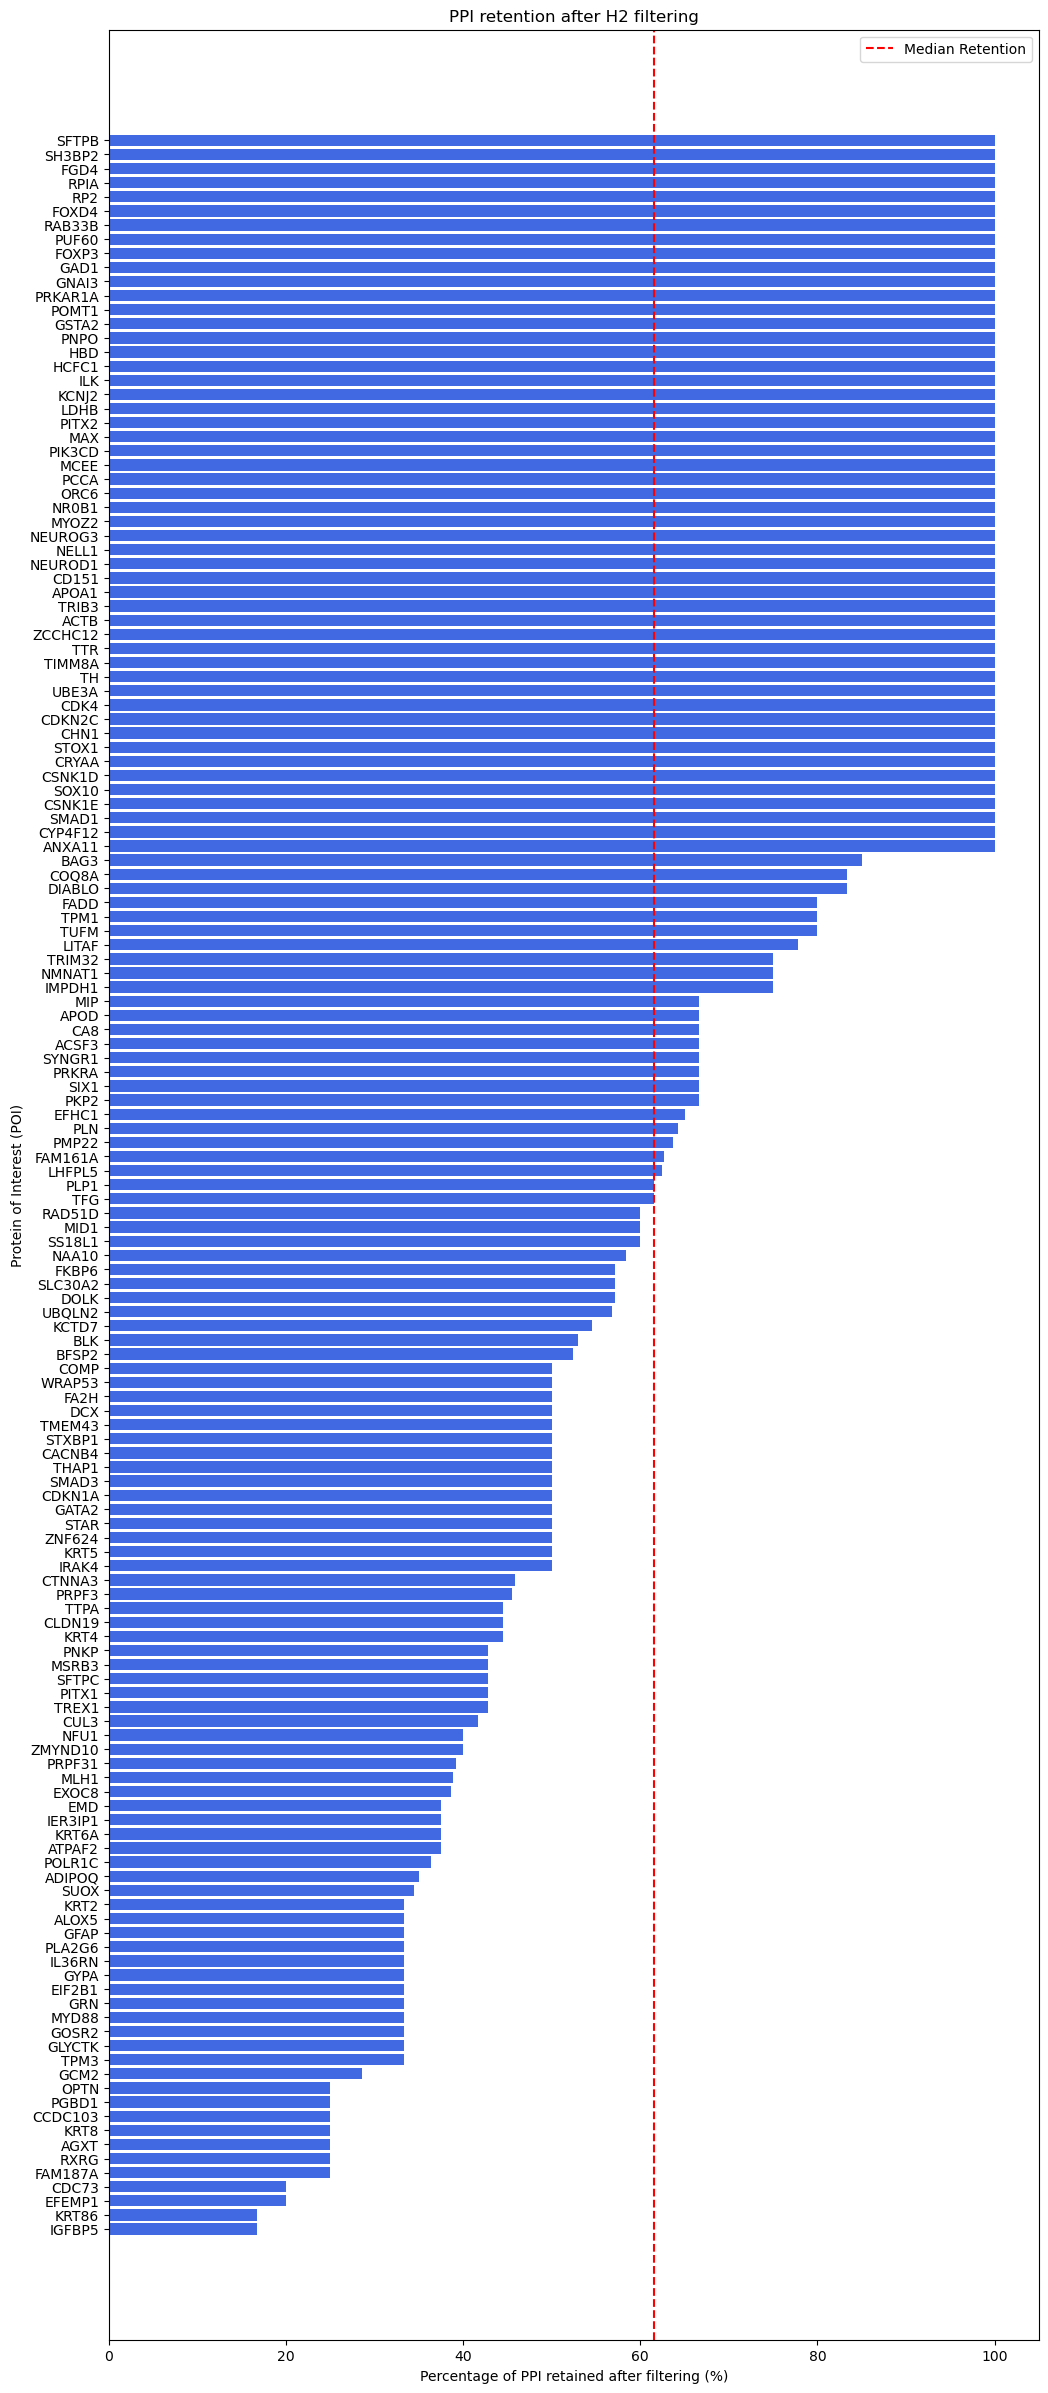

In [5]:
#Plot results
plt.figure(figsize=(12, 30))
plt.barh(ppi_loss_df["POI"], ppi_loss_df["PPI Retained (%)"], color="royalblue")
plt.axvline(ppi_loss_df["PPI Retained (%)"].median(), color="red", linestyle="dashed", label="Median Retention")
plt.xlabel("Percentage of PPI retained after filtering (%)")
plt.ylabel("Protein of Interest (POI)")
plt.title("PPI retention after H2 filtering")
plt.legend()
plt.show()

Since we now have a structured dataset tracking which PPIs are retained across different tissues and cell types, we can perform a systemic analysis to gain deeper biological insights.

1. PPI Prevalence across cell types & tissues: 

- Goal:
Identify which PPIs are most prevalent across multiple cell types & tissues.
For example, if ACSF3-PPP1R13B appears in 5 different cell types but ACSF3-RAB28 appears in only 2, then ACSF3-PPP1R13B is a more systemically relevant interaction.

- Approach:
    - Count how many unique tissues and cell types each retained PPI appears in.
    - Rank PPIs by their prevalence (across cell types/tissues).
    - Generate a heatmap or bar plot to visualize which interactions are most widespread.


2. Stability Score: Interaction Retention across filters. 

- Goal:
Determine which PPIs are highly stable (consistently retained) vs. conditionally retained (filtered in specific conditions).

- Approach:
    - Compute a stability score for each PPI: (Number of conditions retained / Number of conditions before filtering)
    - A high stability score (e.g., 90% retention) means the interaction persists across multiple conditions.
    - Identify condition-specific PPIs (interactions that survive filtering in some cell types but not others).


3. Tissue-Specific vs. Systemic PPIs

- Goal:
Differentiate tissue-specific vs. ubiquitous interactions.

- Approach:
    - Categorize PPIs as tissue-specific if they appear in only 1-2 tissues.
    - Categorize PPIs as systemic if they appear in multiple tissues.
    - Generate a tissue-PPI network where:
            Nodes = Proteins
            Edges = Interactions
            Edge thickness = Number of tissues where the interaction is present
      

4. Functional Enrichment of highly retained PPIs

- Goal:
Determine if highly retained PPIs are functionally related.

- Approach:
    - Extract highly retained PPIs (e.g., >70% retention).
    - Perform GO enrichment (Biological Process, Molecular Function) on retained interactors.
    - Identify common pathways or processes enriched in stable interactions.


5. Interaction Network Graph (PPI Clusters)

- Goal:
Build a network graph to visually represent interaction clusters.

- Approach: Use NetworkX or Cytoscape to:
    - Cluster interactors based on shared cell types/tissues.
    - Highlight hubs (proteins with many connections).
    - Detect interaction modules (subnetworks that co-exist in specific conditions).
    - Identify core regulatory PPIs that appear across multiple conditions.

In [6]:
import networkx as nx

#Define directory for H2 filtered files
input_dir_H2 = "./results_11032025/Jess_PPI_21032025/PPI_preprocessed_15042025/PPI_contextualization/filtered_Step2_H2/Sorted_final_results/"

#Find all processed H2 files
h2_files = [f for f in os.listdir(input_dir_H2) if f.endswith("_Sorted_S2_H2_24042025.xlsx")]
len(h2_files) #passed moderate to robust compensation criteria 

149

In [7]:
#Initialize storage for PPI tracking
ppi_counts = {}
ppi_tissue_counts = {}

#Process each H2 file
for file in h2_files:
    poi_name = file.split("_")[0]  #Extract POI name
    file_path = os.path.join(input_dir_H2, file)

    #Load H2 dataset
    df_h2 = pd.read_excel(file_path)

    #Extract PPI & Tissue information
    for _, row in df_h2.iterrows():
        ppi = row["PPI"]
        tissue = row["Tissue"]
        cell_type = row["Cell Type"]

        #Track the occurrence of each PPI across cell types
        if ppi not in ppi_counts:
            ppi_counts[ppi] = set()
            ppi_tissue_counts[ppi] = set()

        ppi_counts[ppi].add(cell_type)
        ppi_tissue_counts[ppi].add(tissue)

#Convert counts to DataFrame
ppi_summary = pd.DataFrame({
    "PPI": list(ppi_counts.keys()),
    "Cell Type Count": [len(v) for v in ppi_counts.values()],
    "Tissue Count": [len(v) for v in ppi_tissue_counts.values()]
})

#Sort by number of cell types where PPI appears
ppi_summary = ppi_summary.sort_values(by="Cell Type Count", ascending=False)

#Save summary to Excel
ppi_summary_path = "./results_11032025/Jess_PPI_21032025/PPI_preprocessed_15042025/PPI_contextualization/PPI_prevalence_summary_H2_analysis_24042025.xlsx"
ppi_summary.to_excel(ppi_summary_path, index=False)

print(f"✅ Successfully saved PPI prevalence summary to {ppi_summary_path}")

✅ Successfully saved PPI prevalence summary to ./results_11032025/Jess_PPI_21032025/PPI_preprocessed_15042025/PPI_contextualization/PPI_prevalence_summary_H2_analysis_24042025.xlsx


In [8]:
# #Plot results
# plt.figure(figsize=(12, 100))
# plt.barh(ppi_summary["PPI"], ppi_summary["Cell Type Count"], color="dodgerblue")
# plt.xlabel("Number of Cell types/states where a PPI appears")
# plt.ylabel("Protein-Protein Interaction (PPI)")
# plt.title("PPI prevalence across cell types/states")
# plt.show()

In [9]:
ppi_summary.head() #PPI summary table => can tell us if a PPI is tissue or cell type/state agnostic 

,PPI,Cell Type Count,Tissue Count
546,PRPF31-HNRNPK,260,34
284,PITX1-PFDN5,251,32
170,FADD-BTG1,251,31
429,GLYCTK-PFDN5,234,32
449,PUF60-SRSF11,230,33


In [10]:
#Determine median tissue count for classification
median_tissue_count = np.median(ppi_summary["Tissue Count"])

#Classify each PPI as Tissue-Specific (<= median) or Tissue-Agnostic (> median)
ppi_summary["Category"] = np.where(ppi_summary["Tissue Count"] > median_tissue_count, "Tissue-Agnostic", "Tissue-Specific")

Avoiding clumsiness in PPI plot:

1. Limit #PPIs plotted: Plot only the top N (e.g., 20–40) most "tissue-agnostic" and "tissue-specific" PPIs, or filter by a minimum "Tissue Count".

2. Sort & group for clarity: Sort so that "tissue-agnostic" (high tissue count) & "tissue-specific" (low tissue count) are grouped.

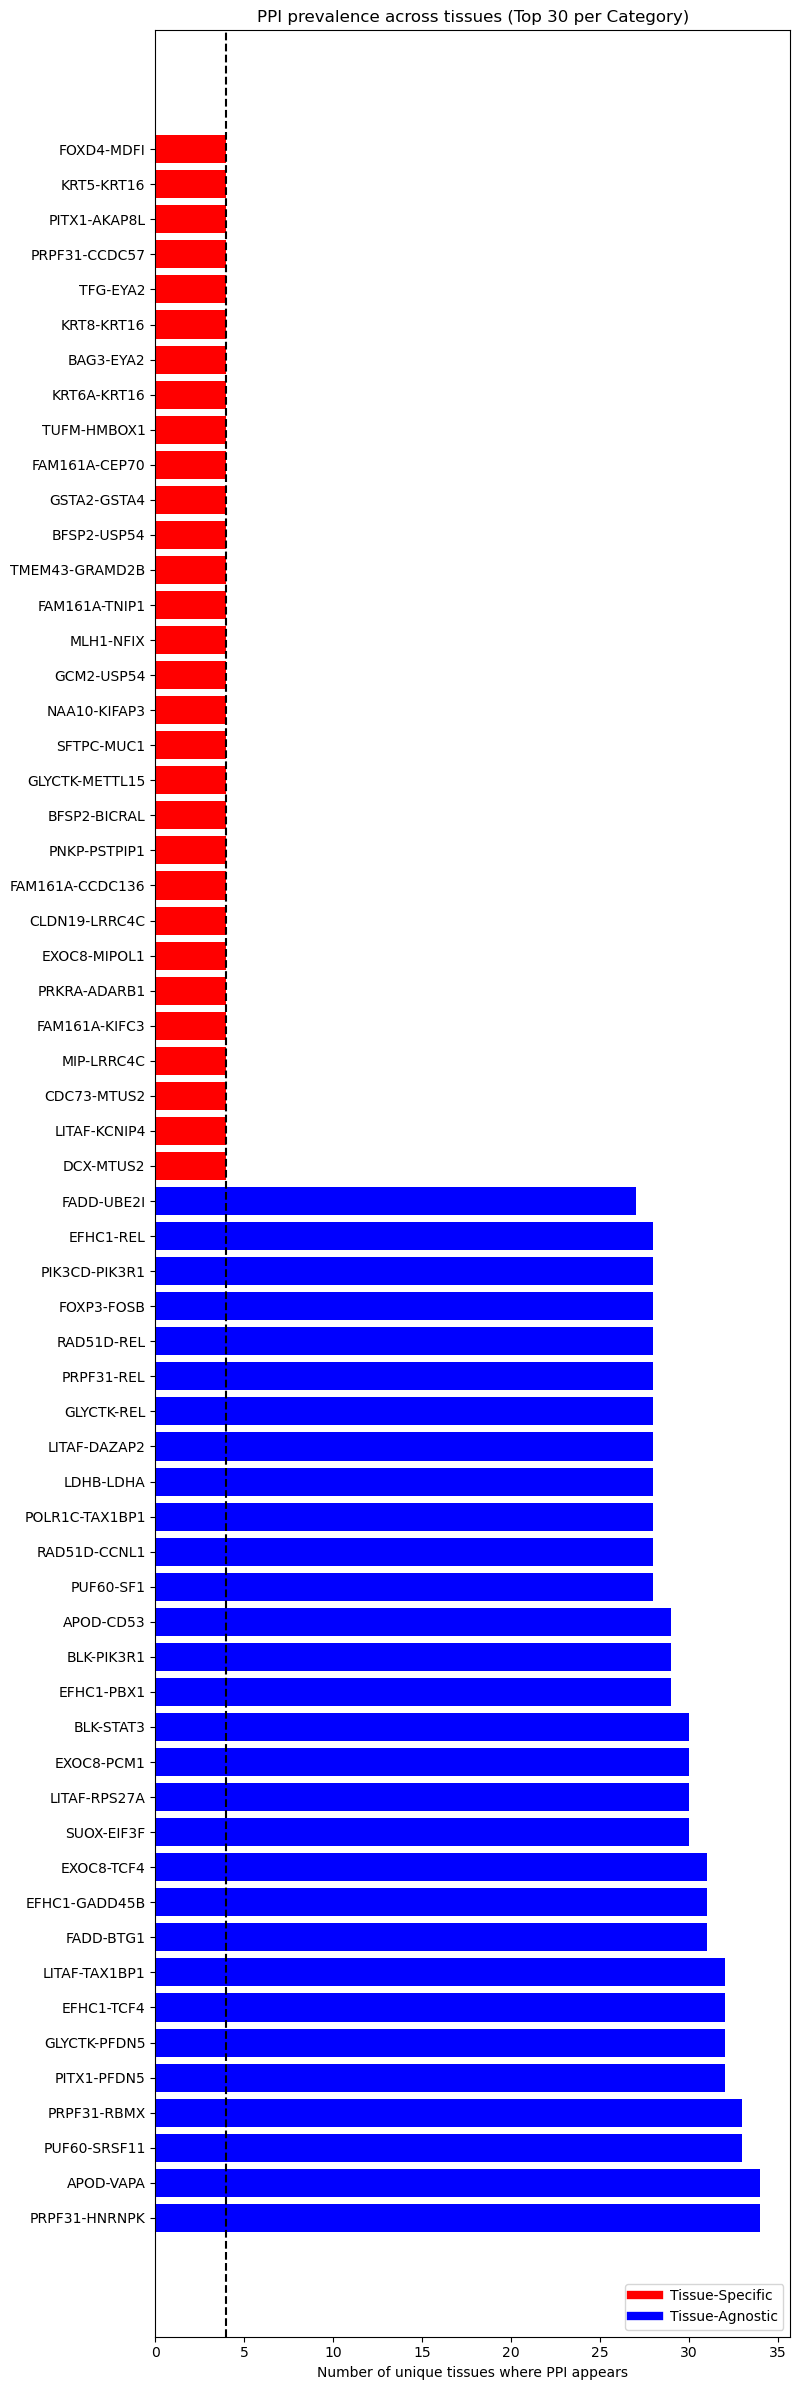

In [11]:
#Filter to top N per category for clarity
N = 30 #can reduce it to 20 or increase  

top_specific = ppi_summary[ppi_summary["Category"] == "Tissue-Specific"].nlargest(N, "Tissue Count")
top_agnostic = ppi_summary[ppi_summary["Category"] == "Tissue-Agnostic"].nlargest(N, "Tissue Count")
plot_df = pd.concat([top_specific, top_agnostic])

#Sort for grouping
plot_df = plot_df.sort_values(by=["Category", "Tissue Count"], ascending=[True, False])

#Assign colors
colors = ["red" if cat == "Tissue-Specific" else "blue" for cat in plot_df["Category"]]

#Set figure size dynamically
fig_height = 0.4 * len(plot_df)
fig, ax = plt.subplots(figsize=(10, fig_height))

#Plot bars
bars = ax.barh(plot_df["PPI"], plot_df["Tissue Count"], color=colors)

#Median line 
median = np.median(ppi_summary["Tissue Count"])
ax.axvline(median, color="black", linestyle="--", label=f"Median: {median:.1f}")

#x & y labels 
ax.set_xlabel("Number of unique tissues where PPI appears")
ax.set_title("PPI prevalence across tissues (Top 30 per Category)")

#Handle legend
handles = [
    plt.Line2D([0], [0], color='red', lw=6, label='Tissue-Specific'),
    plt.Line2D([0], [0], color='blue', lw=6, label='Tissue-Agnostic')
]
ax.legend(handles=handles, loc='lower right')

#Improve spacing
plt.tight_layout()
plt.subplots_adjust(left=0.35)
ax.tick_params(axis='y', labelsize=10)
plt.show()

- Cell type-agnostic means a PPI appears broadly across many cell types (not restricted to one/few).

- Cell type-specific means a PPI is restricted to a particular cell type or a small subset

We will use a threshold to define "Cell type-specific" vs. "Cell type-agnostic". Let's assume that if a PPI appears in less than 25% of the total unique cell types, it's "Cell type-specific"; otherwise, it's "Cell type-agnostic".

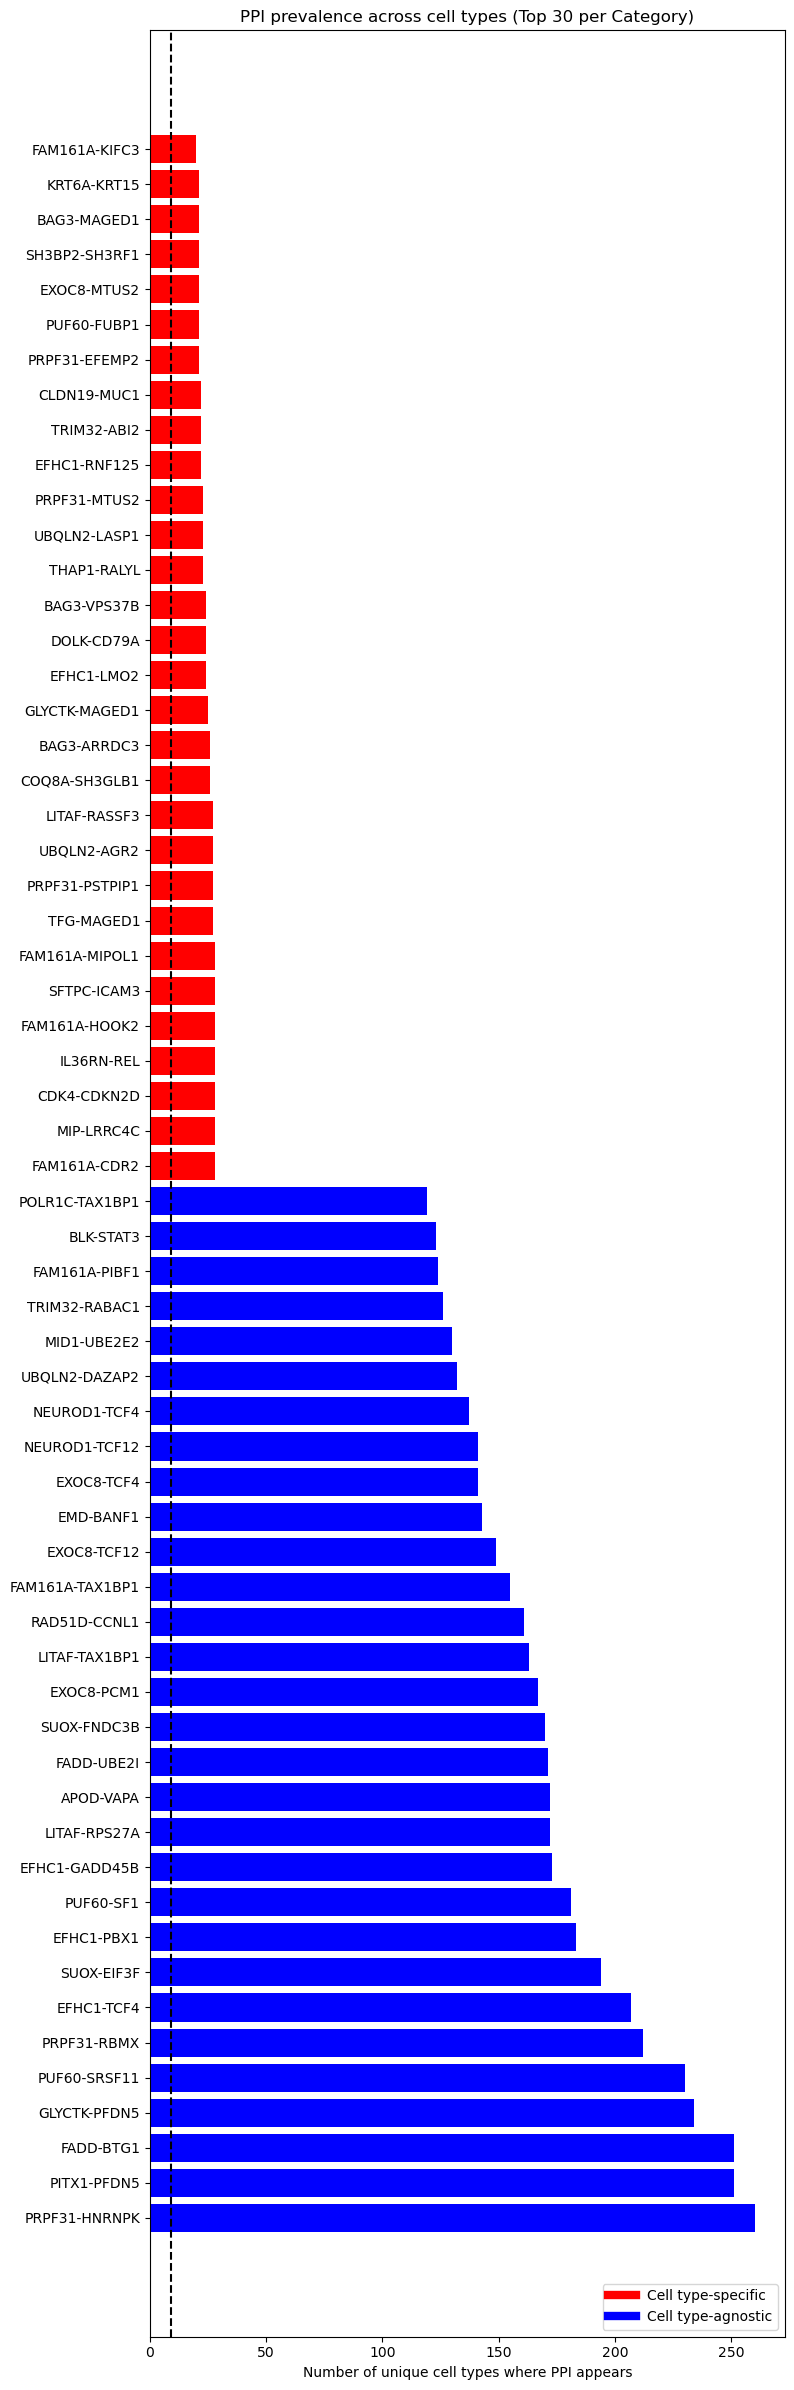

In [12]:
#1. Determine threshold for defining "Cell type-specific"
total_unique_cell_types = ppi_summary["Cell Type Count"].nunique() #Total unique cell type
threshold_percentage = 0.25 #25% cut off
threshold = int(total_unique_cell_types * threshold_percentage)

#2. Assign categories based on the threshold
def assign_category(count):
    if count <= threshold:
        return "Cell type-specific"
    else:
        return "Cell type-agnostic"

ppi_summary["Category"] = ppi_summary["Cell Type Count"].apply(assign_category)

#3. Filter to top N per category for clarity
N = 30
top_specific = ppi_summary[ppi_summary["Category"] == "Cell type-specific"].nlargest(N, "Cell Type Count")
top_agnostic = ppi_summary[ppi_summary["Category"] == "Cell type-agnostic"].nlargest(N, "Cell Type Count")
plot_df = pd.concat([top_specific, top_agnostic])

#4. Sort for grouping
plot_df = plot_df.sort_values(by=["Category", "Cell Type Count"], ascending=[True, False])

#5. Assign colors
colors = ["red" if cat == "Cell type-specific" else "blue" for cat in plot_df["Category"]]

#6. Set figure size dynamically
fig_height = 0.4 * len(plot_df)
fig, ax = plt.subplots(figsize=(10, fig_height))

#7. Plot
bars = ax.barh(plot_df["PPI"], plot_df["Cell Type Count"], color=colors)

#8. Median line (optional, for all data)
median = np.median(ppi_summary["Cell Type Count"])
ax.axvline(median, color="black", linestyle="--", label=f"Median: {median:.1f}")

#9. Labels
ax.set_xlabel("Number of unique cell types where PPI appears")
ax.set_title("PPI prevalence across cell types (Top 30 per Category)")

#10. Legend
handles = [
    plt.Line2D([0], [0], color='red', lw=6, label='Cell type-specific'),
    plt.Line2D([0], [0], color='blue', lw=6, label='Cell type-agnostic')
]
ax.legend(handles=handles, loc='lower right')

#11. Improve spacing
plt.tight_layout()
plt.subplots_adjust(left=0.35)
ax.tick_params(axis='y', labelsize=10)

plt.show()


To show all PPIs & classify them into tissue or cell type agnostic vs specific, it's better to consider a histogram or boxplot of "Tissue Count" or "Cell Type Count" by category instead of a bar plot

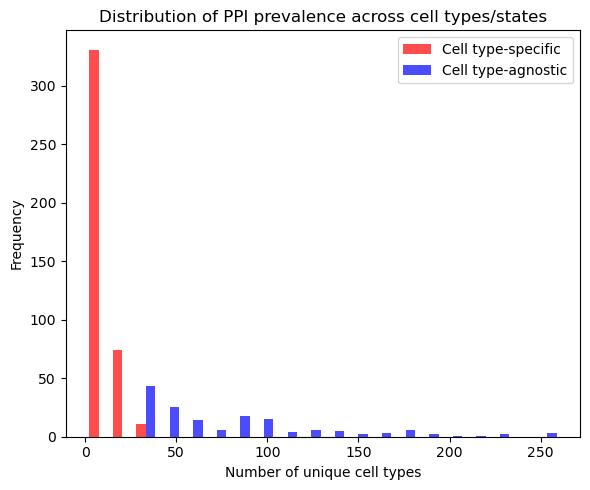

In [13]:
#Create the histogram
plt.figure(figsize=(6, 5))
plt.hist(
    [ppi_summary[ppi_summary["Category"] == "Cell type-specific"]["Cell Type Count"],
     ppi_summary[ppi_summary["Category"] == "Cell type-agnostic"]["Cell Type Count"]],
    bins=20,  # Adjust the number of bins as needed
    color=["red", "blue"],
    label=["Cell type-specific", "Cell type-agnostic"],
    alpha=0.7  # Transparency
)

plt.xlabel("Number of unique cell types")
plt.ylabel("Frequency")
plt.title("Distribution of PPI prevalence across cell types/states") 
plt.legend(loc="upper right")
plt.grid(False) #Removing grids
plt.tight_layout() #Adjust the padding
plt.show()


<Figure size 500x400 with 0 Axes>

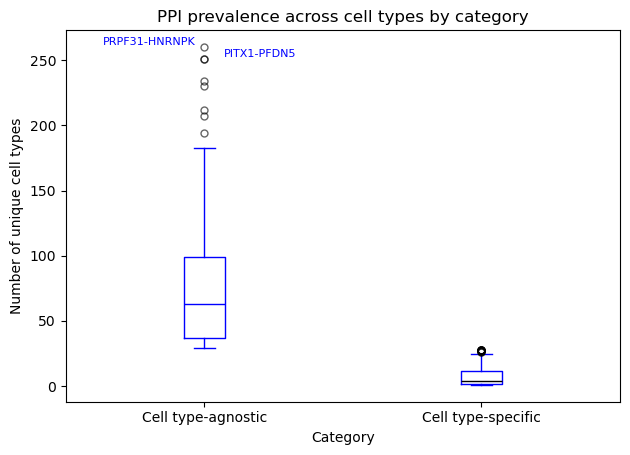

In [15]:
#Determine which PPIs to highlight as outliers
n_highlight = 2

def highlight_outliers(df, category, n=n_highlight):
    top_n = df[df["Category"] == category].nlargest(n, "Cell Type Count")
    return top_n.index.tolist()

#Identify outliers to highlight
specific_outliers = highlight_outliers(ppi_summary, "Cell type-specific")
agnostic_outliers = highlight_outliers(ppi_summary, "Cell type-agnostic")

#Create the boxplot
plt.figure(figsize=(5, 4))

#Define colors
specific_color = "red"
agnostic_color = "blue"

#Create a boxplot without a solid fill
bp = ppi_summary.boxplot(column="Cell Type Count", by="Category", vert=True, patch_artist=False,
                         boxprops=dict(color=agnostic_color),  # Box outline color
                         capprops=dict(color=agnostic_color),   # Cap color
                         whiskerprops=dict(color=agnostic_color), # Whisker color
                         flierprops=dict(marker="o", markersize=5, linestyle="none", markeredgecolor="black"), # Hollow outliers
                         medianprops=dict(color="black"),
                         showfliers=True,
                         return_type="dict")

plt.ylabel("Number of unique cell types")
plt.title("PPI prevalence across cell types by category") # Updated title
plt.suptitle("")  # Remove the default title
plt.xlabel("Category")
plt.grid(False)

#Customize outlier colors and highlight specific outliers
for i, category in enumerate(bp.keys()):
    box_color = specific_color if category == "Cell type-specific" else agnostic_color
    #Change median color
    bp[category]["medians"][0].set_color(box_color)
    bp[category]["boxes"][0].set_color(box_color) #setting the boxes colors as well

    #Change outlier colors and highlight specific outliers
    for flier in bp[category]["fliers"]:
        flier.set(marker='o', color=box_color, alpha=0.6)

    outlier_indices = specific_outliers if category == "Cell type-specific" else agnostic_outliers
    outlier_data = ppi_summary.loc[outlier_indices]

    #Adjust text label positions to minimize overlap
    text_offsets = np.linspace(-0.2, 0.2, len(outlier_indices)) #Creating the spaces around the texts.

    for j, index in enumerate(outlier_indices):
        x = i + 1
        y = ppi_summary.loc[index, "Cell Type Count"]
        plt.text(x + text_offsets[j], y, ppi_summary.loc[index, "PPI"], fontsize=8,
                 ha='center', va='bottom', color=box_color) #Coloring the label with the box_color.


plt.tight_layout()
plt.show()
